In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm # for SARIMAX model, gives best model summary

**Goal:** The objective of this project is to build a trading model that results in capital preservation and growth above a buy and hold strategy and that cannot be attributed to randomness. The underlying asset, bitcoin, is highly volatile, with substantial swings up or down on a daily basis, so a trading strategy that mitigates downside is valuable.

**Define a simple quantitative trading strategy:** The output of a quantitative trading strategy is one or more trading signals. A trading signal identifies a security and how much to go long or short that particular security. My simple strategy involving one security, bitcoin, has one binary signal 0 or +1, where 0 means to go fully short the security and +1 means to go fully long the security.

**Process:** Once I have a time series containing the trading signal and a time series containing the return of the underlying security, I wrote a function that takes the two time series and returns a time series of the trading strategy return as well as accuracy.

**Measurement:** Good strategies have high return with low volatility and low volatility compared to the benchmark. Also, return should not be attributable to chance. To examine these attributes, I will plot several charts:
- The Equity Curve: The equity curve is the standard tool for measuring performance of a strategy and the first one that I will look at. The equity curve refers to the cumulative return of the strategy over time. Here I plot the performance of the voting classifier strategy against bitcoin buy and hold strategy (HODL).
- Rolling Returns: I look at rolling weekly returns to provide a wider view of how the strategy has performed
- Random Binomial distribution versus my strategies: This will test the hypothesis as to whether the winningness of the strategy is due to random chance. Visually, if the strategy returns are outside the randomness distribution, I can assume the strategy outperformance is due to information. Otherwise, I will calculate p-value with 5% significance level.
- Accuracy score and wins/losses size statistics: Win rate is how many trades won out of how many trades taken. If I win 60 trades out of a 100, the win rate is 60%. The shortcoming of this statistic is that it doesn’t account for how big winning and losing trades are. If gains aren’t as big relative to losses, a win rate of +50% is the goal. Short term traders often strive for a win rate above 50% and winning trades that are at least slightly bigger than losers. 

**A Note on calculation:** The log return for a time period is the sum of the log returns of partitions of the time period.  For example the log return for a year is the sum of the log returns of the days within the year.

## Base ARIMA model using only bitcoin daily price action
### Step 1: pull in the dataframe

In [24]:
df = pd.read_csv('../data/BTC-USD.csv', index_col='Date', parse_dates=True) # source Yahoo Finance

In [25]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1980 entries, 2014-09-17 to 2020-02-17
Data columns (total 6 columns):
Open         1980 non-null float64
High         1980 non-null float64
Low          1980 non-null float64
Close        1980 non-null float64
Adj Close    1980 non-null float64
Volume       1980 non-null int64
dtypes: float64(5), int64(1)
memory usage: 108.3 KB


In [27]:
df.columns = [x.lower() for x in df.columns]
df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume'], dtype='object')

### Step 2: EDA and feature engineering

In [42]:
def figure(x,y, title, label):
    _=plt.figure(figsize=(15,8))
    _=plt.plot(x,y, label=label)
    _=plt.title(title,y=1.03, fontsize=14)
    return _

Text(0.5, 1.03, 'Bitcoin Price (USD)')

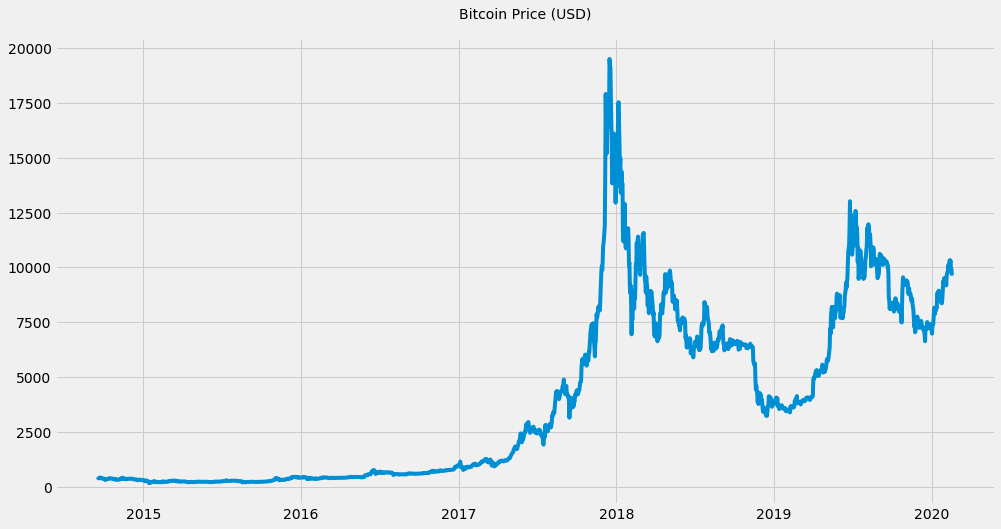

In [43]:
figure(df.index, df.close,'Bitcoin Price (USD)','BTC')

**Is bitcoin price a random walk?**
I apply the Augmented Dickey Fuller Test to check

In [30]:
# plotting the data shows non-stationarity (random walk with a drift), apply Augmented Dickey Fuller Test to confirm 
# Null-hypothesis is that data is non-stationary; reject null if p-value < 0.05

results = adfuller(df['close'])

print(f'the p-value of the DF test on prices is {results[1]}')
print('Fail to reject null hypothesis that data is non-stationary')

the p-value of the DF test on prices is 0.48037041692604365
Fail to reject null hypothesis that data is non-stationary


**Apply Transforms to achieve relative stationarity**

In [31]:
# first differencing results in rejecting the null hyporthesis that data is non-stationary, but plotting shows 
# uneven variance. 
btc = df['close']
btc_diff1 = btc.diff(1).dropna()
result = adfuller(btc_diff1)
print(f'the p-value of the DF test on price first difference is {round(result[1],2)} with t-stat {round(result[0],2)}')

the p-value of the DF test on price first difference is 0.0 with t-stat -8.46


Text(0.5, 1.03, 'First Difference (Price)')

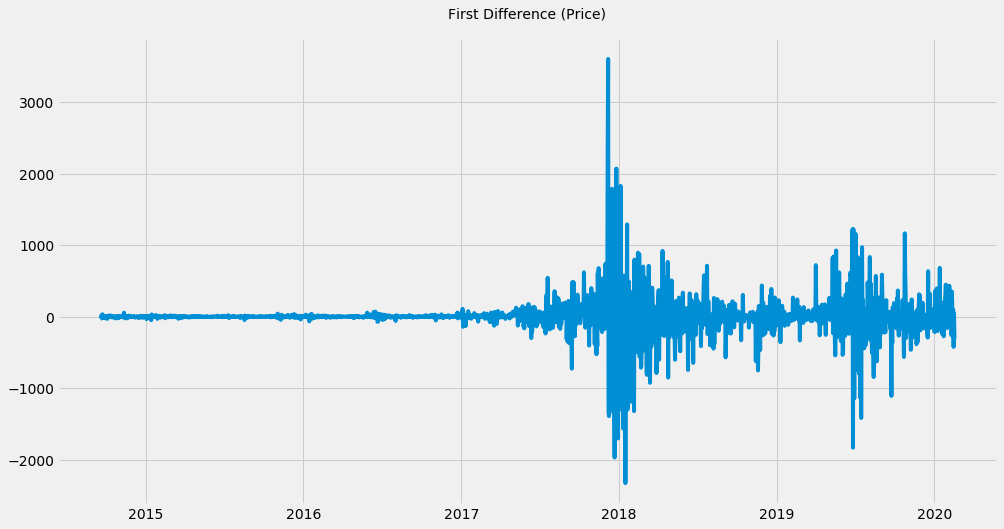

In [32]:
figure(btc_diff1.index, btc_diff1,"First Difference (Price)", label=None)

In [33]:
# logging the returns yields a better result. The DF t-stat is larger and the plot confirms stationarity
btc_log = np.log((btc/btc.shift(1)).dropna())
result_log = adfuller(btc_log)
print(f'the p-value of the DF test on log-return is {round(result_log[1],2)} with t-stat {round(result_log[0],2)}')

the p-value of the DF test on log-return is 0.0 with t-stat -13.35


Text(0.5, 1.03, 'Log-Returns')

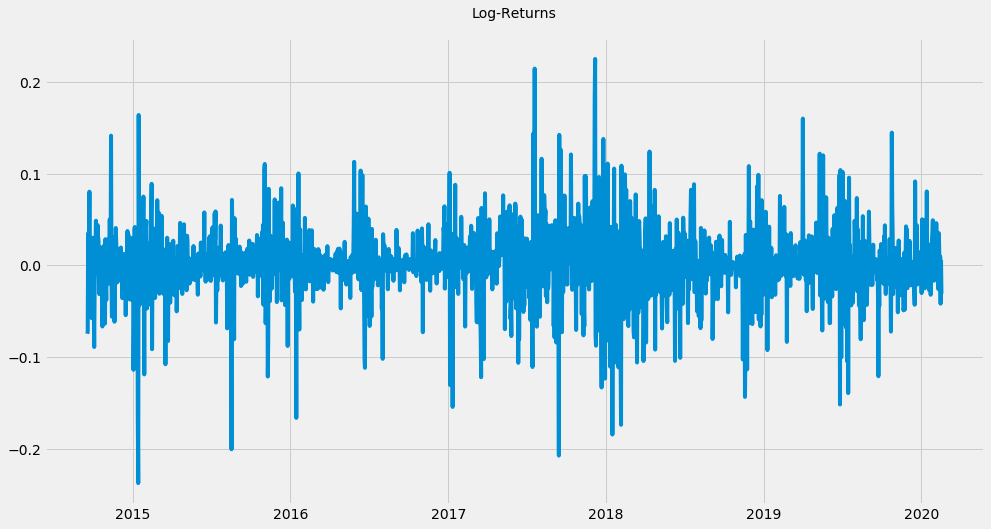

In [34]:
figure(btc_log.index, btc_log, "Log-Returns", label=None)

### Step 3: Model Selection
**Can I use an ARMA model?**
Stock returns are often modeled as white noise. A white noise time series is a sequence of uncorrelated random variables that are identically distributed. For white noise, I cannot forecast future observations based on the past as no lags are statistically different from zero.

autocorrelation of daily log returns is 0.51%


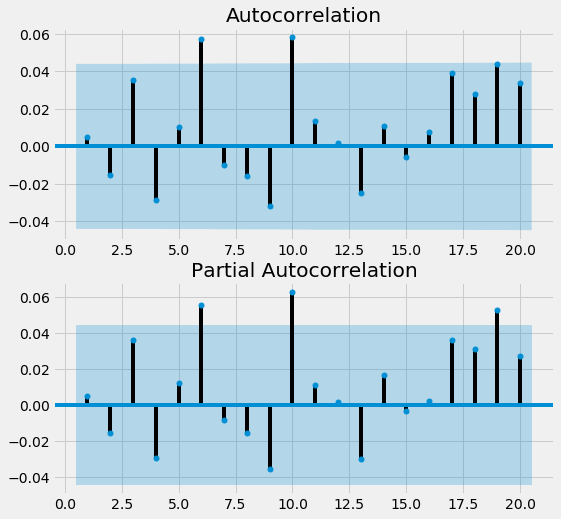

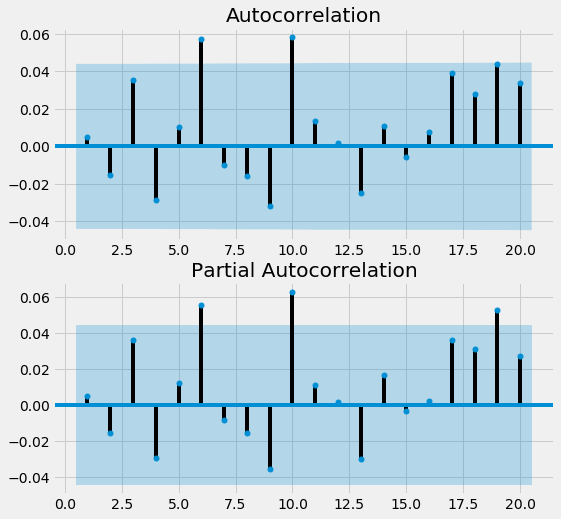

In [35]:
# the autocorrelation plot on log daily returns shows significant lags at 6 and 10 at the 95% confidence level 
'''not sure why the plots print twice, but ignore the last two'''
autocorrelation = btc_log.autocorr()
print(f'autocorrelation of daily log returns is {round(autocorrelation*100,2)}%')
fig, ax = plt.subplots(2,1, figsize=(8,8))

plot_acf(btc_log, zero=False, lags=20, ax=ax[0])
plot_pacf(btc_log, zero=False, lags=20, ax=ax[1])

**This appears to be an ARMA model, but ACF and PACF plots don't follow any obvious pattern for determining ARMA order:**
- for AR(p) model: ACF tails off. PACF cuts off after lag p
- for MA(q) model: ACF cuts off after lag q. PACF tails off.
- for ARMA(p,q) model: ACF tails off. PACF tails off.

**Therefore, I wrote function to grid search over potential model orders to find the best set.**

In [36]:
#function to train test split time series data
def train_test_split(df, train_size): # train size is decimal (eg. 0.80 for 80%)
    train_len = int(train_size * df.shape[0])
    train_split = df[:train_len]
    test_split = df[train_len:]
    return train_split, test_split  

In [37]:
# Create a size for the training set that is 80% of the total number of samples
btc_log_train, btc_log_test = train_test_split(btc_log, 0.80)
print(btc_log.shape, btc_log_train.shape, btc_log_test.shape)

(1979,) (1583,) (396,)


In [38]:
# grid search best ARMA model hyperparameters p and q
def grid_search_ARMA(df, p_max, q_max, p_min=0, q_min=0): # number of lags you want to search with default min zero
    # list to store search results
    order_aic_bic = []

    # loop over p values within defined range AR(p)
    for p in range(p_min, p_max):
        # loop over q values within defined range MA(q)
        for q in range(q_min, q_max):
            try:
                # create and fit ARMA(p,q) model
                model = ARIMA(df, order=(p,0,q))
                result = model.fit(disp=False)

                # append p,q,aic,bic tuple
                order_aic_bic.append((p, q, result.aic, result.bic))
            except:
                order_aic_bic.append((p, q, None, None))

    # construct dataframe from order_aic_bic
    order_df = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])
    return order_df.sort_values(by=['aic']), order_df.sort_values(by=['bic'])

In [39]:
# not necessary to run this grid search again; it takes a while to run. Results below
'''acf and pacf show significant lags up to 10, so set max there'''
# btc_aic_df, btc_bic_df = grid_search_ARMA(btc_log_train, 11, 11)

'acf and pacf show significant lags up to 10, so set max there'

**grid search shows the best result for ARMA(8,5)**

There are two information criterion used for ARMA model selection:
- Akaike Information Criterion (AIC)
    - Lower AIC indicates a better model (can be positive or negative and not based on absolute value Source: Baguley, Thomas. Serious stats: A guide to advanced statistics for the behavioral sciences. Palgrave Macmillan, 2012. (page 402)
    - Likes to choose simple models with lower order (penalizes complexity)
- Baysian Information Criterion (BIC)
    - Similar to AIC, lower value suggests a better model
    - likes simpler models with lower order
- Difference between AIC and BIC is how much they penalize model complexity
    - BIC favors simpler models more than AIC
    - AIC is better at choosing predictive models
    - BIC is better at choosing explanatory models

In [40]:
# saved results of grid search and imported below
btc_aic_df = pd.read_csv('../data/btc_aic.csv',index_col='Unnamed: 0')
btc_aic_df.head()

,p,q,aic,bic
93,8,5,-5762.709242,-5682.203086
43,3,10,-5762.655523,-5682.149367
119,10,9,-5761.898904,-5649.190286
83,7,6,-5760.183241,-5679.677085
116,10,6,-5760.052614,-5663.445227


In [41]:
btc_bic_df = btc_aic_df.sort_values('bic')
btc_bic_df.head()

,p,q,aic,bic
0,0,0,-5755.370724,-5744.636570
1,0,1,-5753.612662,-5737.511431
11,1,0,-5753.603508,-5737.502277
2,0,2,-5752.245515,-5730.777207
22,2,0,-5752.147774,-5730.679466


### Step 4: Fit base ARMA model with no exogenous variables on train set

In [25]:
# fit model
model = sm.tsa.SARIMAX(btc_log_train, order=(8,0,5))
results = model.fit(disp=False, maxiter=1000)

# calculate mean absolute error from residuals (MAE)
mae = np.mean(np.abs(results.resid))
print(f'Mean Absolute Error is {round(100 * mae,2)}%')

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Mean Absolute Error is 2.57%


In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                  close   No. Observations:                 1583
Model:               SARIMAX(8, 0, 5)   Log Likelihood                2889.523
Date:                Sat, 29 Feb 2020   AIC                          -5751.047
Time:                        14:41:34   BIC                          -5675.908
Sample:                    09-18-2014   HQIC                         -5723.130
                         - 01-17-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0920      0.650     -0.142      0.887      -1.366       1.182
ar.L2         -0.2373      0.493     -0.481      0.630      -1.204       0.729
ar.L3         -0.2818      0.335     -0.841      0.401      -0.939       0.375
ar.L4          0.3870      0.356      1.088      0.277      -0.310       1.084
ar.L5          0.1810      0.470      0.385      0.700      -0.740       1.102
ar.L6          0.0839      0.022      3.746      0.000       0.040       0.128
ar.L7         -0.0375      0.060     -0.626      0.532      -0.155       0.080
ar.L8          0.0245      0.061      0.403      0.687      -0.095       0.144
ma.L1          0.1085      0.651      0.167      0.868      -1.167       1.384
ma.L2          0.2250      0.492      0.457      0.648      -0.740       1.190
ma.L3          0.3218      0.340      0.946      0.344      -0.345       0.988
ma.L4         -0.4165      0.372     -1.118      0.264      -1.147       0.314
ma.L5         -0.1741      0.496     -0.351      0.725      -1.145       0.797
sigma2         0.0015   3.12e-05     48.722      0.000       0.001       0.002
===================================================================================
Ljung-Box (Q):                       36.60   Jarque-Bera (JB):              1659.12
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.76   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Looking at Ljung-Box (Q) and Jarque-Bera (JB) from summary output to determine goodness of fit based on residuals**

**Goal: The residuals should be uncorrelated white Gaussian noise centered around zero**

Q Null Hypothesis: There are no correlations in the residuals
- Looking at prob(Q), FTR Null. No issues with autocorrelation

JB Null Hypothesis: The residuals are normally distributed
- Looking at prob(JB), Reject Null. Residuals are not normally distributed

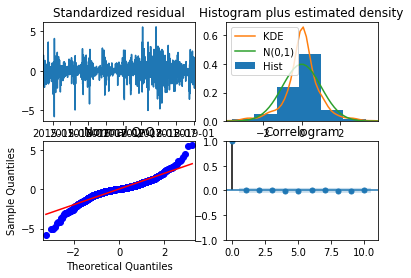

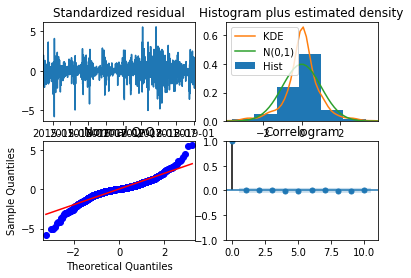

In [27]:
# Histogram and Q-Q plots confirm residuals are not normally distributed
# Non-normality in the error terms 
# Standardized residual plot and correlogram confirm residuals are not autocorrelated
# Which means there are no significant lags that are unaccounted for
results.plot_diagnostics()

### Step 5: Predict on train data, visualize and analyze results

In [28]:
# making one-step-ahead predictions over the latest 90 days of training data

# generate predictions
one_day_forecast = results.get_prediction(start=-90) 

# extract prediction mean
mean_forecast = one_day_forecast.predicted_mean

# get confidence intervals of predictions
confidence_intervals = one_day_forecast.conf_int()

print(mean_forecast[:10])

2018-10-20    0.001531
2018-10-21    0.000934
2018-10-22   -0.001368
2018-10-23    0.000160
2018-10-24   -0.000343
2018-10-25    0.001306
2018-10-26   -0.000592
2018-10-27   -0.000345
2018-10-28   -0.000380
2018-10-29    0.000697
Freq: D, dtype: float64


In [29]:
confidence_intervals.head()

,lower close,upper close
2018-10-20,-0.074887,0.077950
2018-10-21,-0.075485,0.077353
2018-10-22,-0.077786,0.075051
2018-10-23,-0.076259,0.076578
2018-10-24,-0.076762,0.076076


In [30]:
# select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower close']
upper_limits = confidence_intervals.loc[:,'upper close']

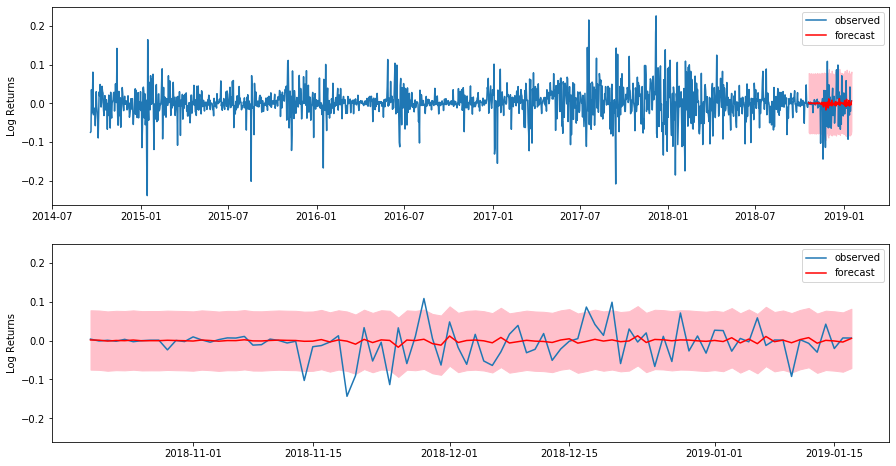

In [31]:
# plotting the observed vs forecast data shows the challenge with predicting returns.
# bitcoin returns are centered around zero with wide variance
fig, ax = plt.subplots(2,1,sharey=True, figsize=(15,8))

# plotting total train set
ax[0].plot(btc_log_train.index, btc_log_train, label='observed')

# plotting just the forecast period
ax[1].plot(mean_forecast.index, btc_log_train[-90:], label='observed')

# set labels, legends and show plot
for i in range(0,2):
    # plot mean predictions
    ax[i].plot(mean_forecast.index,mean_forecast , color='r', label='forecast')
    
    # shade the area between confidence limits
    ax[i].fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')
    
    # set labels
    ax[i].set_ylabel('Log Returns')
    ax[i].legend()

In [44]:
def prediction_quality(forecast, observed): #takes two series
    '''takes the model one-step-ahead predictions and simulates a trading strategy.
    Also, generates outcomes for confusion matrix'''
    false_positive = 0 # predicted positive return, actually negative
    false_negative = 0 # predicted negative return, actually positive
    true_positive = 0 # predicted positive return, actually positive
    true_negative = 0 # predicted negative return, actually negative
    returns = []
    
    # Trading Strategy decision algorithm:
    # When return is predicted negative, short BTC (sell) 
    # When return is predicted positive, long BTC (buy/hold)
    for i in forecast.index: 
        if forecast[i] >= 0 and observed[i] < 0: # forecast positive, observed negative
            false_positive += 1
            returns.append(observed[i])
        elif forecast[i] < 0 and observed[i] >= 0: # forecast negative, observed positive
            false_negative += 1
            returns.append(-observed[i])
        elif forecast[i] < 0 and observed[i] < 0: # forecast negative, observed negative
            true_negative += 1
            returns.append(-observed[i])
        else: # forecast positive, observed positive
            true_positive +=1
            returns.append(observed[i])
            
    returns = pd.Series(returns)
    
    return returns, false_positive, false_negative, true_positive, true_negative
        

In [33]:
model_returns, FP, FN, TP, TN = prediction_quality(mean_forecast, btc_log_train[-90:])

In [34]:
print(f'FP: {FP}, FN: {FN}, TP: {TP}, TN: {TN}') # classification results from base model trading strategy

FP: 23, FN: 25, TP: 20, TN: 22


In [41]:
model_returns[:5] # head of resurns from base model trading strategy

0    0.003671
1   -0.001055
2   -0.000742
3   -0.001762
4   -0.003099
dtype: float64

In [ ]:
# create confusion matrix with output from prediction quality function above
positives = [TP, FP]
negatives = [FN, TN]
rows = ['actual positive', 'actual negative']
cols = ['predicted positive', 'predicted negative']

In [45]:
def conf_matrix(positives, negatives, rows, cols):
    df = pd.DataFrame(list(zip(positives, negatives)), index=rows, columns=cols)
    accuracy = round((positives[0] + negatives[1]) / (sum(positives) + sum(negatives)),2)
    return df, accuracy

In [37]:
# base model confusion matrix and accuracy for train set
base_ARMA_conf_matrix, base_ARMA_accuracy = conf_matrix(positives, negatives, rows, cols)
print(f'base model accuracy score is {base_ARMA_accuracy} on training data')
base_ARMA_conf_matrix

base model accuracy score is 0.47 on training data


,predicted positive,predicted negative
actual positive,20,25
actual negative,23,22


In [46]:
def output_df(target, num_steps, forecast, model_returns): 
    #target can be train or test. If train, number of steps is arbitrary. If test, number of steps is len(test data)
    '''function takes strategy returns, joins with forecast and observed returns, calculates cumulative % return
    and return on $100 for trading strategy and HODL strategy and makes one output dataframe'''
    
    data = pd.concat([target[-num_steps:], forecast],axis=1)
    data = pd.concat([data.reset_index(),pd.DataFrame(model_returns)], axis=1)
    data.columns = ['date', 'btc_return', 'forecast_return','strategy_return']
    data = data.set_index('date')
    data['btc_cum'] = np.cumsum(data['btc_return'])
    data['strategy_cum'] = np.cumsum(data['strategy_return'])
    data['btc_USD_return'] = 100 * (1 + data['btc_cum'])
    data['strategy_USD_return'] = 100 * (1 + data['strategy_cum'])
    
    return data
    

In [39]:
# output_df = output_df(btc_log_train, 90, mean_forecast, model_returns)

In [77]:
# saved to csv and imported df
output_df = pd.read_csv('train_base_model_output.csv', index_col='date', parse_dates=True)
output_df.head()

,btc_return,forecast_return,strategy_return,btc_cum,strategy_cum,btc_USD_return,strategy_USD_return
date,,,,,,,
2018-10-20,0.003671,0.001531,0.003671,0.003671,0.003671,100.367125,100.367125
2018-10-21,-0.001055,0.000934,-0.001055,0.002617,0.002617,100.261666,100.261666
2018-10-22,0.000742,-0.001368,-0.000742,0.003358,0.001875,100.335841,100.187491
2018-10-23,-0.001762,0.000160,-0.001762,0.001596,0.000113,100.159647,100.011297
2018-10-24,0.003099,-0.000343,-0.003099,0.004695,-0.002986,100.469550,99.701395


In [78]:
# function plots cum return of $100 for HODL vs trading strategy
def figure_gain(x,y1,y2,title, label1, label2):
    g = figure(x,y1, title, label=label1)
    g = plt.plot(x,y2, label=label2)
    g = plt.legend()
    g = plt.ylabel('USD($)')
    
    return g

Text(0, 0.5, 'USD($)')

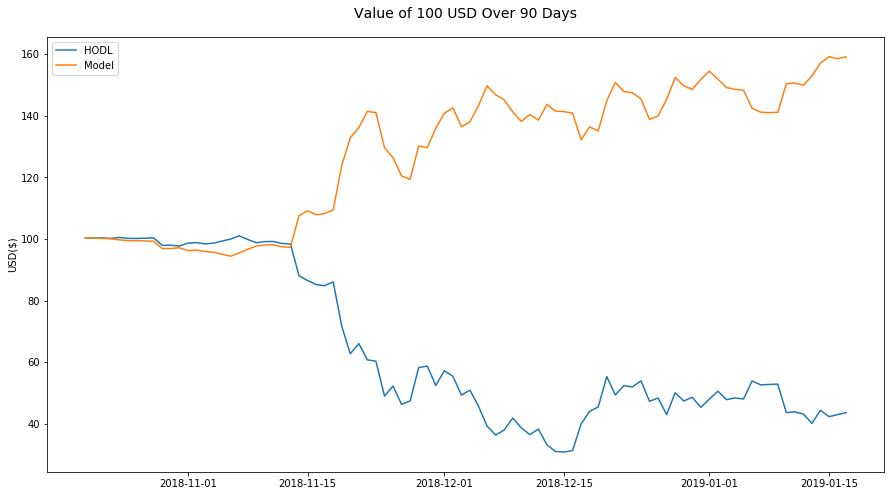

In [79]:
figure_gain(output_df.index, output_df.btc_USD_return, output_df.strategy_USD_return, 'Value of 100 USD Over 90 Days','HODL','Model')

**Base Model Results Discussion (Train Set):** The base model performed about as expected on the train set given the 47% accuracy score - no better than a coin flip. Over this time period, it happens to result in growth of capital versus a buy and hold strategy ("HODL" in bitcoin parlance). Next, I will predict on the test data to see whether the accuracy score deteriorates.   

### Step 6: Predict base ARMA model with no exogenous variables on test set

In [2]:
test_period = len(btc_log_test)
mae_base = []
forecast_base = []
for step in range(test_period):
    
    data = btc_log[:step - test_period]
    
    # fit model
    mod = sm.tsa.SARIMAX(data, order=(8,0,5))
    result = mod.fit(disp=False, maxiter=1000)
    
    # calculate mean absolute error from residuals (MAE)
    mae = np.mean(np.abs(result.resid))
    mae_base.append(mae)
    
    # making one-step-ahead predictions on test data
    one_day_forecast = result.get_forecast(steps=1)
    mean_forecast = one_day_forecast.predicted_mean
    forecast_base.append(mean_forecast)
    

In [284]:
arma_base_backtest = pd.read_csv('arma_base_backtest.csv', index_col='date', parse_dates=True)
arma_base_backtest.head()

,forecast,mae
date,,
2019-01-18,-0.0055,0.025652
2019-01-19,-0.0010,0.025636
2019-01-20,0.0029,0.025605
2019-01-21,-0.0025,0.025610
2019-01-22,0.0018,0.025597


In [287]:
arma_base_backtest = arma_base_backtest.join(btc_log_test, how='left', rsuffix='_')
arma_base_backtest.head()

,forecast,mae,close
date,,,
2019-01-18,-0.0055,0.025652,-0.005650
2019-01-19,-0.0010,0.025636,0.019152
2019-01-20,0.0029,0.025605,-0.034809
2019-01-21,-0.0025,0.025610,-0.006961
2019-01-22,0.0018,0.025597,0.007951


In [289]:
bmodel_returns, bFP, bFN, bTP, bTN = prediction_quality(arma_base_backtest.forecast, arma_base_backtest.close)

In [290]:
# create confusion matrix with output from prediction quality function above
positives = [bTP, bFP]
negatives = [bFN, bTN]
rows = ['actual positive', 'actual negative']
cols = ['predicted positive', 'predicted negative']

In [293]:
backtest_conf_matrix_test, backtest_accuracy_test = conf_matrix(positives, negatives, rows, cols)

In [294]:
print(f'base backtest model accuracy score is {backtest_accuracy_test} on test data')
backtest_conf_matrix_test

base backtest model accuracy score is 0.52 on test data


,predicted positive,predicted negative
actual positive,116,92
actual negative,97,91


In [296]:
backtest_output_df = output_df(arma_base_backtest.close, len(arma_base_backtest.close), arma_base_backtest.forecast, bmodel_returns)

In [301]:
backtest_output_df = pd.read_csv('backtest_output.csv', index_col='date', parse_dates=True)
backtest_output_df.head()

,btc_return,forecast_return,strategy_return,btc_cum,strategy_cum,btc_USD_return,strategy_USD_return
date,,,,,,,
2019-01-18,-0.005650,-0.0055,0.005650,-0.005650,0.005650,99.435018,100.564982
2019-01-19,0.019152,-0.0010,-0.019152,0.013502,-0.013502,101.350189,98.649811
2019-01-20,-0.034809,0.0029,-0.034809,-0.021307,-0.048311,97.869293,95.168915
2019-01-21,-0.006961,-0.0025,0.006961,-0.028269,-0.041349,97.173149,95.865059
2019-01-22,0.007951,0.0018,0.007951,-0.020318,-0.033399,97.968202,96.660112


Text(0, 0.5, 'USD($)')

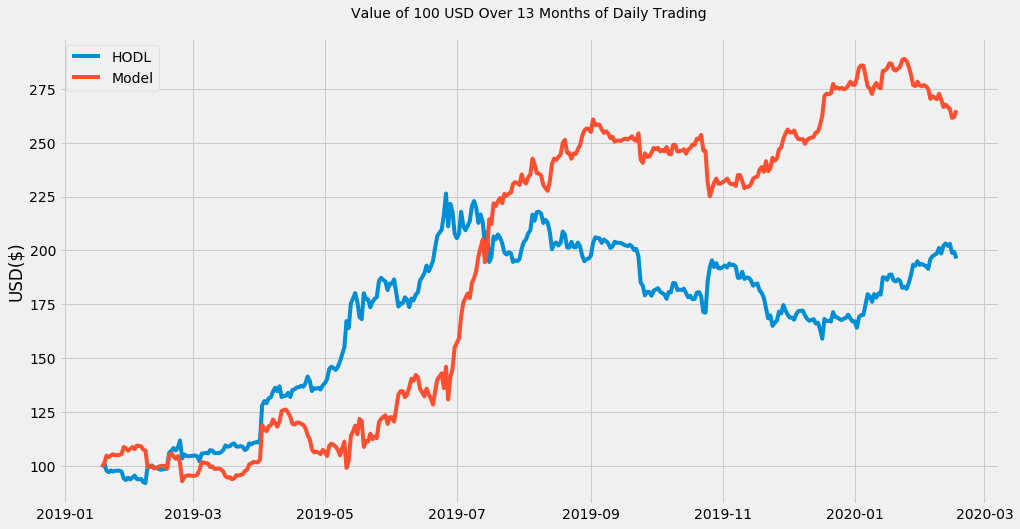

In [302]:
figure_gain(backtest_output_df.index, backtest_output_df.btc_USD_return, test_output_df.strategy_USD_return, 'Value of 100 USD Over 13 Months of Daily Trading','HODL','Model')

Text(0.5, 1.03, 'Backtest: Mean Absolute Error Over Time')

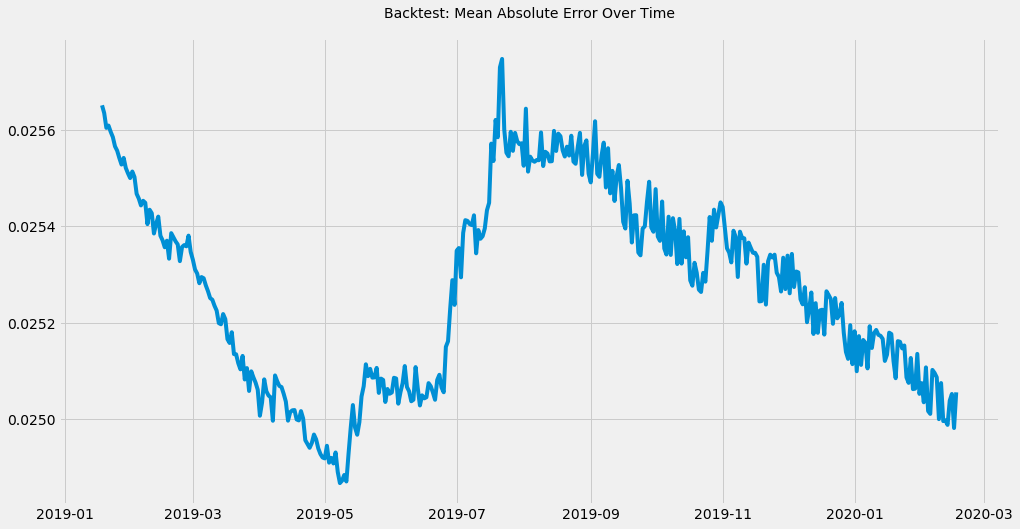

In [305]:
figure(arma_base_backtest.index, arma_base_backtest.mae,'Backtest: Mean Absolute Error Over Time','MAE')

**Base Model Results Discussion (Test Set):** The base model performed as expected on the test set as well. Results were within the range of random chance. Over this time period, it results in growth of capital versus a HODL strategy. Next, I will use an ARIMAX model to build on this base ARMA model. Specifically, I will explore the explanatory power of adding other asset classes and technical indicators. Because there is no autocorrelation in the residuals, there is no unaccounted for seasonal component.

## ARIMAX Model

In [47]:
df = pd.read_csv('../data/trade_df.csv', index_col='Date', parse_dates=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1656 entries, 2015-08-07 to 2020-02-17
Data columns (total 34 columns):
btc_close               1656 non-null float64
spx_close               1656 non-null float64
mchi_close              1656 non-null float64
eem_close               1656 non-null float64
gld_close               1656 non-null float64
agg_close               1656 non-null float64
tips_close              1656 non-null float64
vix_close               1656 non-null float64
iai_value               1639 non-null float64
eth_close               1656 non-null float64
7D                      1656 non-null float64
14D                     1656 non-null float64
20D                     1656 non-null float64
50D                     1656 non-null float64
rsi7                    1649 non-null float64
rsi14                   1642 non-null float64
rsi20                   1636 non-null float64
rsi50                   1606 non-null float64
mchi_close_coint        1656 non-null float64
e

In [15]:
btc_log_df = btc_log.to_frame(name='btc_return') # convert btc log return series to df

In [49]:
df = df.join(btc_log_df, how='left') #join with main df

In [17]:
x_vars = ['7D','14D','20D','50D','rsi7','rsi14','rsi20','rsi50', 'mchi_close_lag','spx_close_lag','eth_close_lag']

In [51]:
# find all combinations of 3 or less exogenous variables
import itertools

def all_combinations(col_names):
    return itertools.chain.from_iterable(
        itertools.combinations(col_names, i + 1)
        for i in range(len(col_names)))

In [52]:
combinations = [list(x) for x in list(all_combinations(x_vars)) if len(x) <= 3]

In [54]:
X = df[x_vars].dropna()

In [55]:
y = df[['btc_return']][-1606:]

In [56]:
X_train, X_test = train_test_split(X, 0.80)
print(X.shape, X_train.shape, X_test.shape)

(1606, 11) (1284, 11) (322, 11)


In [57]:
y_train, y_test = train_test_split(y, 0.80)
print(y.shape, y_train.shape, y_test.shape)

(1606, 1) (1284, 1) (322, 1)


### Step 1: Fit models for all combinations of 1,2, and 3 exogenous variables 

In [58]:
# formatting function to map variable name combinations to index position in x_vars
test = ['mchi_close_lag', 'spx_close_lag', 'eth_close_lag']

def col_index(combos):
    test_index = []
    for index, name in enumerate(x_vars):
        if name in combos:
            test_index.append(index)
    return test_index

col_index(test)

[8, 9, 10]

In [84]:
def armax_forecasts():
    forecasts = {}
    for combo in combinations:  

        header = col_index(combo)
        # fit model
        model = sm.tsa.SARIMAX(y_train, order=(8,0,5), exog=X_train[combo])
        results = model.fit(disp=False, maxiter=200)

        # calculate mean absolute error from residuals (MAE)
        mae = np.mean(np.abs(results.resid))

        '''making one-step-ahead predictions over the latest 90 days of training data'''

        # generate predictions
        one_day_forecast = results.get_prediction(start=-90) 

        # extract prediction mean
        mean_forecast = one_day_forecast.predicted_mean

        # add mean forecasts to dictionary
        forecasts[f'{header}'] = mean_forecast

    models_df = pd.DataFrame.from_dict(forecasts)
    return models_df
    

In [ ]:
# takes a while to fit the 230 model combos; no need to run, output saved and imported below
# models_df = armax_forecasts()
# models_df.columns = [header.strip('[]') for header in models_df.columns]

In [63]:
# model forecasts for 230 models. Column numbers are exogenous variable combo names mapped to numbers
models_df = pd.read_csv('../data/ARMA_model_forecasts.csv', index_col='Unnamed: 0', parse_dates=True)
models_df.head()

,0,1,2,3,4,5,6,7,8,9,...,"6, 7, 8","6, 7, 9","6, 7, 10","6, 8, 9","6, 8, 10","6, 9, 10","7, 8, 9","7, 8, 10","7, 9, 10","8, 9, 10"
2019-01-02,-0.000524,-0.000671,-0.000677,-0.000708,0.007478,0.004064,0.003722,0.002534,-0.000088,0.000159,...,0.012480,0.011668,0.011597,0.003778,0.004845,0.005358,0.002483,0.003406,0.003876,-0.000242
2019-01-03,0.007617,0.007469,0.007457,0.007432,0.006557,0.011457,0.011532,0.010473,0.007838,0.008215,...,0.009864,0.016553,0.016596,0.011486,0.012453,0.013021,0.010325,0.011243,0.011798,0.007663
2019-01-04,-0.005301,-0.005426,-0.005455,-0.005487,0.006736,-0.001716,-0.001672,-0.003050,-0.005848,-0.005090,...,0.010118,0.005420,0.005749,-0.001966,-0.001052,-0.000078,-0.003486,-0.002720,-0.001726,-0.005983
2019-01-05,0.000835,0.000710,0.000678,0.000652,0.006609,0.006891,0.004325,0.003001,0.001725,0.002013,...,0.010317,0.011765,0.011418,0.005066,0.006260,0.006865,0.003675,0.004596,0.005204,0.001560
2019-01-06,-0.006476,-0.006599,-0.006630,-0.006652,0.008474,-0.000643,-0.002426,-0.003940,-0.005392,-0.005183,...,0.016036,0.010149,0.009789,-0.001665,-0.000827,-0.000131,-0.003259,-0.002682,-0.002038,-0.005657


In [97]:
# creating a summary table for the 230 models
output = []
for col in models_df.columns:
    model_returns, FP, FN, TP, TN = prediction_quality(models_df[col], y_train.btc_return[-90:])
    positives = [TP, FP]
    negatives = [FN, TN]
    accuracy = round((positives[0] + negatives[1]) / (sum(positives) + sum(negatives)),2)
    output.append([col, sum(model_returns), FP, FN, TP, TN, accuracy])

output = pd.DataFrame(output, columns=['vars','model_returns','FP','FN','TP','TN','accuracy'])

In [98]:
armax_models = output.sort_values(by='accuracy', ascending=False)
armax_models.head()

,vars,model_returns,FP,FN,TP,TN,accuracy
94,"0, 4, 9",0.832135,18,9,41,22,0.70
130,"1, 4, 9",0.826469,20,7,43,20,0.70
132,"1, 5, 6",0.630671,24,4,46,16,0.69
45,"4, 5",0.751229,12,16,34,28,0.69
96,"0, 5, 6",0.630671,24,4,46,16,0.69


In [99]:
# true positives over all cases model interpreted positive
armax_models['precision'] = round(armax_models.TP / (armax_models.TP + armax_models.FP),2) 
# true positives over all observed positives
armax_models['recall'] = armax_models.TP / (armax_models.TP + armax_models.FN) 
# true negative rate is true negatives over all observed negatives
armax_models['TNR'] =  armax_models.TN / (armax_models.TN + armax_models.FP) 

In [3]:
# saved and imported summary table for the 230 models
armax_models = pd.read_csv('../data/train_armax_summary.csv', index_col='Unnamed: 0')
armax_models.head()

,vars,model_returns,FP,FN,TP,TN,accuracy,precision,recall,TNR
94,"0, 4, 9",0.832135,18,9,41,22,0.70,0.69,0.82,0.55
130,"1, 4, 9",0.826469,20,7,43,20,0.70,0.68,0.86,0.50
132,"1, 5, 6",0.630671,24,4,46,16,0.69,0.66,0.92,0.40
45,"4, 5",0.751229,12,16,34,28,0.69,0.74,0.68,0.70
96,"0, 5, 6",0.630671,24,4,46,16,0.69,0.66,0.92,0.40


### Step 2: Analyze which are best models to include in a voting classifier
I'm not basing strategy on highest returns because that's not a generalizeable metric. I'll look at accuracy, precision, recall, and true negative rate for evaluation. The charts below graph model returns as a function of accuracy. There is a clear linear relationship. The most accurate models have the highest returns. This is also the case with precision - high precision tends to produce good results. However, as recall approaches 1, model performance deteriorates. There is a cluster of models with high true negative rates that performed well. **Given the visualization, I will optimize for accuracy, precision, and TNR, and let recall be a byproduct.**

**Process for building Voting Classifier**
My approach is to choose roughly the top five models for each metric (accuracy, precision, and TNR), adjust for overlap, and select an odd number of models to avoid 50/50 voting ties.


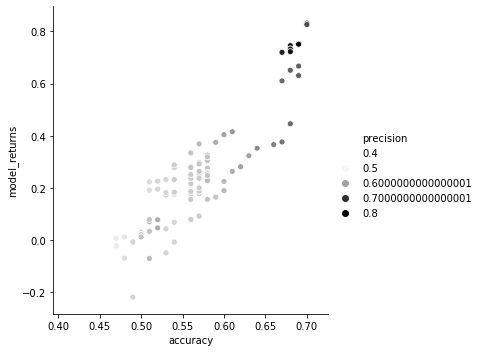

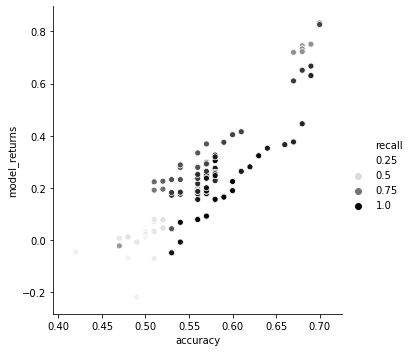

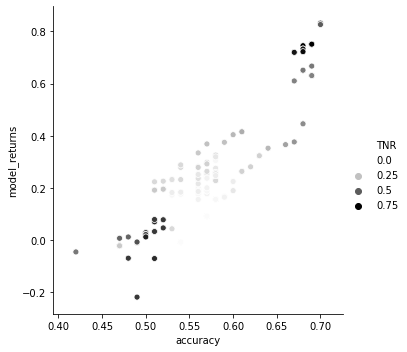

In [17]:
# plots of relevant metrics
hue = ['precision', 'recall', 'TNR']

for i, score in enumerate(hue):
    sns.relplot(x='accuracy', y='model_returns', data = armax_models, kind='scatter', hue=score, palette='Greys')

In [107]:
best_precision = [model for model in armax_models.sort_values(by='precision', ascending=False).head().vars]

In [108]:
best_accuracy = [model for model in armax_models.sort_values(by='accuracy', ascending=False).head().vars]

In [109]:
best_TNR = [model for model in armax_models.sort_values(by='TNR', ascending=False).head().vars]

In [113]:
# after narrowing down the list to unique models, there are 11 - 10 three variable models and 1 two variable.
# Because this is an odd number of models, I will not drop the two variable model.
armax_model_list = list(set(best_precision + best_accuracy + best_TNR))
armax_model_list

['4, 5, 10',
 '4, 5, 9',
 '0, 4, 5',
 '4, 5',
 '2, 4, 5',
 '4, 5, 6',
 '3, 4, 5',
 '0, 4, 9',
 '1, 4, 9',
 '5, 6, 7',
 '1, 4, 5']

In [62]:
# retrieving the independent variable labels for each model in the voting classifier
def to_name(model_list):    
    model_names = []
    for model in model_list:
        each_model = []
        for i in model.split(','):
            var = x_vars[int(i)]
            each_model.append(var)
        model_names.append(each_model)
    return model_names

In [252]:
armax_model_names = to_name(armax_model_list)
armax_model_names

[['rsi7', 'rsi14', 'eth_close_lag'],
 ['rsi7', 'rsi14', 'spx_close_lag'],
 ['7D', 'rsi7', 'rsi14'],
 ['rsi7', 'rsi14'],
 ['20D', 'rsi7', 'rsi14'],
 ['rsi7', 'rsi14', 'rsi20'],
 ['50D', 'rsi7', 'rsi14'],
 ['7D', 'rsi7', 'spx_close_lag'],
 ['14D', 'rsi7', 'spx_close_lag'],
 ['rsi14', 'rsi20', 'rsi50'],
 ['14D', 'rsi7', 'rsi14']]

### Step 3: Build voting classifier from selected models

In [229]:
# raw forecast of daily return for each model
voting_forecasts = models_df[armax_model_list]
voting_forecasts.head()

,"4, 5, 10","4, 5, 9","0, 4, 5","4, 5","2, 4, 5","4, 5, 6","3, 4, 5","0, 4, 9","1, 4, 9","5, 6, 7","1, 4, 5"
2019-01-02,0.016182,0.015883,0.015374,0.015797,0.015367,0.014400,0.014978,0.005266,0.005110,0.018190,0.015343
2019-01-03,0.005871,0.005606,0.005178,0.005511,0.005179,0.003588,0.004832,0.003620,0.003579,0.013101,0.005170
2019-01-04,0.007753,0.007430,0.007064,0.007410,0.007050,0.005605,0.006731,0.004598,0.004490,0.013952,0.007053
2019-01-05,0.006248,0.006066,0.005594,0.005926,0.005572,0.004030,0.005283,0.003333,0.003338,0.013275,0.005588
2019-01-06,0.025127,0.024939,0.024336,0.024830,0.024297,0.023927,0.024026,0.006652,0.006657,0.022483,0.024323


In [230]:
# added target
voting_forecasts = voting_forecasts.join(y_train.btc_return[-90:], how='left')
voting_forecasts.head()

,"4, 5, 10","4, 5, 9","0, 4, 5","4, 5","2, 4, 5","4, 5, 6","3, 4, 5","0, 4, 9","1, 4, 9","5, 6, 7","1, 4, 5",btc_return
2019-01-02,0.016182,0.015883,0.015374,0.015797,0.015367,0.014400,0.014978,0.005266,0.005110,0.018190,0.015343,0.025657
2019-01-03,0.005871,0.005606,0.005178,0.005511,0.005179,0.003588,0.004832,0.003620,0.003579,0.013101,0.005170,-0.027422
2019-01-04,0.007753,0.007430,0.007064,0.007410,0.007050,0.005605,0.006731,0.004598,0.004490,0.013952,0.007053,0.005452
2019-01-05,0.006248,0.006066,0.005594,0.005926,0.005572,0.004030,0.005283,0.003333,0.003338,0.013275,0.005588,-0.003251
2019-01-06,0.025127,0.024939,0.024336,0.024830,0.024297,0.023927,0.024026,0.006652,0.006657,0.022483,0.024323,0.058447


In [139]:
'''converts raw forecast into returns generated from the strategy according to buy and sell 
rules from "prediction quality" function and stores them in a dictionary. Also generates summary output''' 
model_returns_dict = {}
output = []
for col in voting_forecasts.columns[:-1]:
    model_returns, FP, FN, TP, TN = prediction_quality(voting_forecasts[col], voting_forecasts.btc_return)
    positives = [TP, FP]
    negatives = [FN, TN]
    accuracy = round((positives[0] + negatives[1]) / (sum(positives) + sum(negatives)),2)
    output.append([col, sum(model_returns), FP, FN, TP, TN, accuracy])
    model_returns_dict[f'{col}'] = model_returns.to_list()

output = pd.DataFrame(output, columns=['vars','model_returns','FP','FN','TP','TN','accuracy'])

**Evaluation of models to include in voting classifier:** Summary metrics for the 11 models shows variation in the confusion matrix for some models. However, the first five models along with model 6 and model 10 appear to have redundant decision logic. All of the aforementioned models include vars 4 and 5, which the algorith weights heavily. For simplicity and to avoid skewing the classifier weights, I will drop all but the bivariate 4,5 model. So the voting classifier will be comprised of five models.
With varied information from each model, the idea is that there may be some score improvement with voting classifier.

In [140]:

output 

,vars,model_returns,FP,FN,TP,TN,accuracy
0,"4, 5, 10",0.751229,12,16,34,28,0.69
1,"4, 5, 9",0.751229,12,16,34,28,0.69
2,"0, 4, 5",0.751229,12,16,34,28,0.69
3,"4, 5",0.751229,12,16,34,28,0.69
4,"2, 4, 5",0.751229,12,16,34,28,0.69
5,"4, 5, 6",0.745344,12,17,33,28,0.68
6,"3, 4, 5",0.751229,12,16,34,28,0.69
7,"0, 4, 9",0.832135,18,9,41,22,0.70
8,"1, 4, 9",0.826469,20,7,43,20,0.70
9,"5, 6, 7",0.630671,24,4,46,16,0.69


In [225]:
# actual strategy performance if implemented for the 5 selected models
model_returns_df = pd.DataFrame(model_returns_dict)
model_returns_df = model_returns_df.join(voting_forecasts[['btc_return']].reset_index())
model_returns_df.set_index('index', inplace=True)

In [64]:
selected_models = ['4, 5','4, 5, 6','0, 4, 9','1, 4, 9','5, 6, 7','btc_return']
model_returns_df = model_returns_df[selected_models]
model_returns_df.head()

In [65]:
# features of selected models
voting_model_names = to_name(selected_models[:-1])
voting_model_names

[['rsi7', 'rsi14'],
 ['rsi7', 'rsi14', 'rsi20'],
 ['7D', 'rsi7', 'spx_close_lag'],
 ['14D', 'rsi7', 'spx_close_lag'],
 ['rsi14', 'rsi20', 'rsi50']]

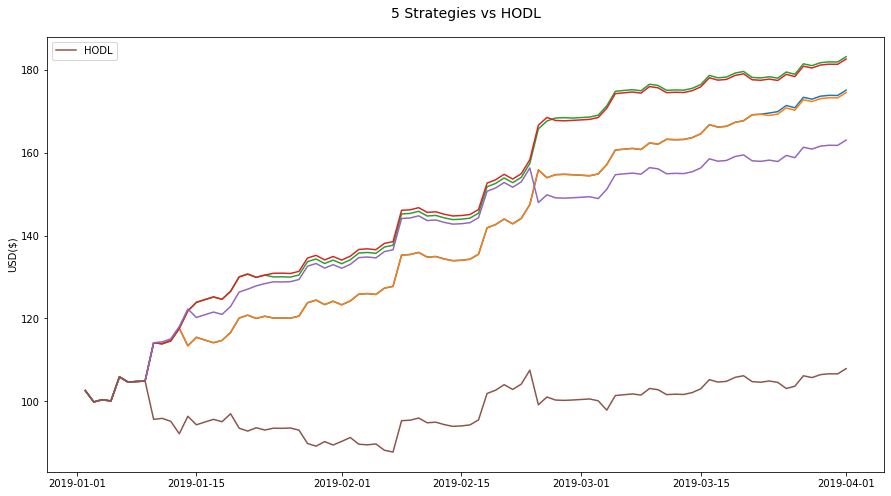

In [227]:
_=plt.figure(figsize=(15,8))
_=plt.title(f'{len(model_returns_df.columns) - 1} Strategies vs HODL', y=1.03, fontsize=14)
_=plt.ylabel('USD($)')

for i, col in enumerate(model_returns_df.columns):
    if i < len(model_returns_df.columns) - 1:
        _= plt.plot(100 * (1 + model_returns_df[col].cumsum()))
    else:
        _= plt.plot(100 * (1 + model_returns_df[col].cumsum()), label='HODL')
        
_=plt.legend()

In [233]:
voting_forecasts = voting_forecasts[selected_models]
voting_forecasts.head()

,"4, 5","4, 5, 6","0, 4, 9","1, 4, 9","5, 6, 7",btc_return
2019-01-02,0.015797,0.014400,0.005266,0.005110,0.018190,0.025657
2019-01-03,0.005511,0.003588,0.003620,0.003579,0.013101,-0.027422
2019-01-04,0.007410,0.005605,0.004598,0.004490,0.013952,0.005452
2019-01-05,0.005926,0.004030,0.003333,0.003338,0.013275,-0.003251
2019-01-06,0.024830,0.023927,0.006652,0.006657,0.022483,0.058447


In [96]:
def classifier(row):
    if row >= 0:
        return 1
    else:
        return 0

In [234]:
for col in voting_forecasts.columns:
    voting_forecasts[f'{col}_v'] = voting_forecasts[col].apply(classifier)

In [235]:
voting_list = [col for col in voting_forecasts.columns if 'v' in col]
votes = voting_forecasts[voting_list[:-1]]
target = voting_forecasts[voting_list[-1]]

In [238]:
votes['sum_votes'] = votes.sum(axis=1)

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [239]:
votes.head()

,"4, 5_v","4, 5, 6_v","0, 4, 9_v","1, 4, 9_v","5, 6, 7_v",sum_votes
2019-01-02,1,1,1,1,1,5
2019-01-03,1,1,1,1,1,5
2019-01-04,1,1,1,1,1,5
2019-01-05,1,1,1,1,1,5
2019-01-06,1,1,1,1,1,5


In [102]:
def decision_rule(row):
    if row > 2: # the third vote is the tie breaker
        return 1
    else:
        return 0    

In [241]:
votes['prediction'] = votes['sum_votes'].apply(decision_rule)

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [242]:
model_returns_df2 = model_returns_df.join(votes[['prediction']], how='left')

In [243]:
model_returns_df2 = model_returns_df2.join(target, how = 'left')

In [244]:
model_returns_df2.head()

,"4, 5","4, 5, 6","0, 4, 9","1, 4, 9","5, 6, 7",btc_return,prediction,btc_return_v
index,,,,,,,,
2019-01-02,0.025657,0.025657,0.025657,0.025657,0.025657,0.025657,1,1
2019-01-03,-0.027422,-0.027422,-0.027422,-0.027422,-0.027422,-0.027422,1,0
2019-01-04,0.005452,0.005452,0.005452,0.005452,0.005452,0.005452,1,1
2019-01-05,-0.003251,-0.003251,-0.003251,-0.003251,-0.003251,-0.003251,1,0
2019-01-06,0.058447,0.058447,0.058447,0.058447,0.058447,0.058447,1,1


In [108]:
def voting_returns(pred, tgt, ret): 
    '''takes series: binary model vote, binary target, bitcoin actual return
        returns as output actual returns from strategy'''
    voting_returns = []
    index = []
    for i in pred.index:
        index.append(i)
        if pred[i] == 1 and tgt[i] == 1: # true positive
            voting_returns.append(ret[i])
        elif pred[i] == 1 and tgt[i] == 0: # false positive
            voting_returns.append(ret[i])
        elif pred[i] == 0 and tgt[i] == 1: # false negative
            voting_returns.append(-ret[i])
        else: # true negative
            voting_returns.append(-ret[i])
    return pd.Series(voting_returns, index=index)

In [245]:
train_voting_returns = voting_returns(model_returns_df2.prediction, model_returns_df2.btc_return_v, model_returns_df2.btc_return) 

In [246]:
train_voting_returns

2019-01-02    0.025657
2019-01-03   -0.027422
2019-01-04    0.005452
2019-01-05   -0.003251
2019-01-06    0.058447
                ...   
2019-03-28   -0.004404
2019-03-29    0.007167
2019-03-30    0.002020
2019-03-31   -0.000306
2019-04-01    0.012774
Length: 90, dtype: float64

#### Confusion matrix for voting classifier

In [112]:
from sklearn.metrics import confusion_matrix, classification_report

In [247]:
print(classification_report(target, votes['prediction']))

              precision    recall  f1-score   support

           0       0.71      0.55      0.62        40
           1       0.69      0.82      0.75        50

    accuracy                           0.70        90
   macro avg       0.70      0.69      0.69        90
weighted avg       0.70      0.70      0.69        90



In [248]:
# confusion matrix on training data
conf_matrix = pd.DataFrame(confusion_matrix(target, votes['prediction']),
                           index = ['actual negative', 'actual positive'], 
                           columns = ['predicted negative', 'predicted positive'])
conf_matrix

,predicted negative,predicted positive
actual negative,22,18
actual positive,9,41


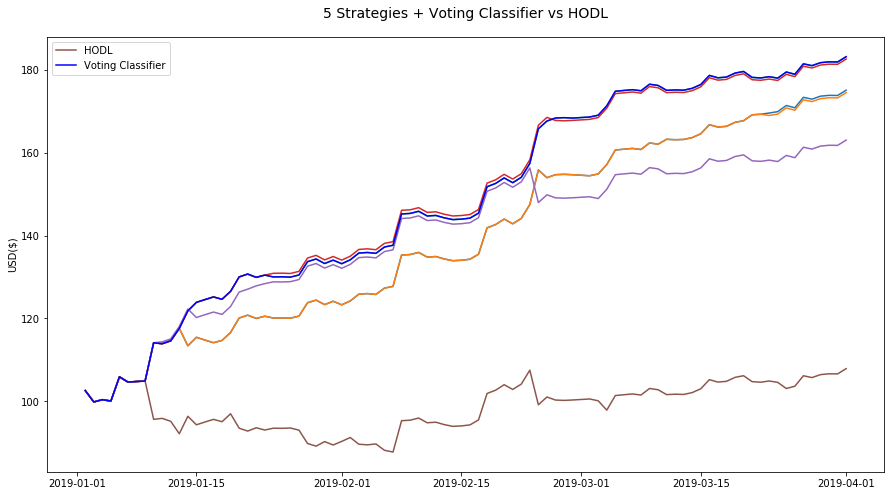

In [249]:
_=plt.figure(figsize=(15,8))
_=plt.title(f'{len(model_returns_df.columns) - 1} Strategies + Voting Classifier vs HODL', y=1.03, fontsize=14)
_=plt.ylabel('USD($)')

for i, col in enumerate(model_returns_df.columns):
    if i < len(model_returns_df.columns) - 1:
        _= plt.plot(100 * (1 + model_returns_df[col].cumsum()))
    else:
        _= plt.plot(100 * (1 + model_returns_df[col].cumsum()), label='HODL')
_=plt.plot(100 * (1 + train_voting_returns.cumsum()), label='Voting Classifier', color='blue')        
_=plt.legend()

**ARMAX Model Results Discussion(Train Set):** Including the exogenous variables improved the accuracy score substantially from the base model. On the train set, accuracy increased from 47% for the base model to as high as 70% for some multivariate models as well as for the voting classifier. I will now predict on the test data to see wheter the voting classifier generalizes better to unseen data than the base model.  

### Step 4: Test Set - Voting classifier

In [71]:
def backtest_model(combo):
    test_period = len(y_test)
    mae_model = []
    forecast = []
    for step in range(test_period):

        
        y_data = y[:step - test_period]
        X_data = X[:step - test_period]


        # fit model
        mod = sm.tsa.SARIMAX(y_data, order=(8,0,5), exog=X_data[combo])
        result = mod.fit(disp=False, maxiter=1000)

        # calculate mean absolute error from residuals (MAE)
        mae = np.mean(np.abs(result.resid))
        mae_model.append(mae)

        # making one-step-ahead predictions on test data
        one_day_forecast = result.get_forecast(steps=1, exog=X_test[combo][step: step + 1])
        mean_forecast = one_day_forecast.predicted_mean
        forecast.append(mean_forecast.to_list)
    return mae_model, forecast

In [79]:
voting_model_names

[['rsi7', 'rsi14'],
 ['rsi7', 'rsi14', 'rsi20'],
 ['7D', 'rsi7', 'spx_close_lag'],
 ['14D', 'rsi7', 'spx_close_lag'],
 ['rsi14', 'rsi20', 'rsi50']]

In [72]:
def voting_forecasts():

    forecasts = {}
    mae_ = []
    period = len(y_test)
    for combo in voting_model_names:  

        header = col_index(combo)
        
        mae, forecast = backtest_model(combo)
        mae_.append((f'mae_{header}', mae))
        forecasts[f'{header}'] = forecast
        
    models_df = pd.DataFrame.from_dict(forecasts)
    return models_df, mae_

In [3]:
test_voting_df, test_voting_mae = voting_forecasts()

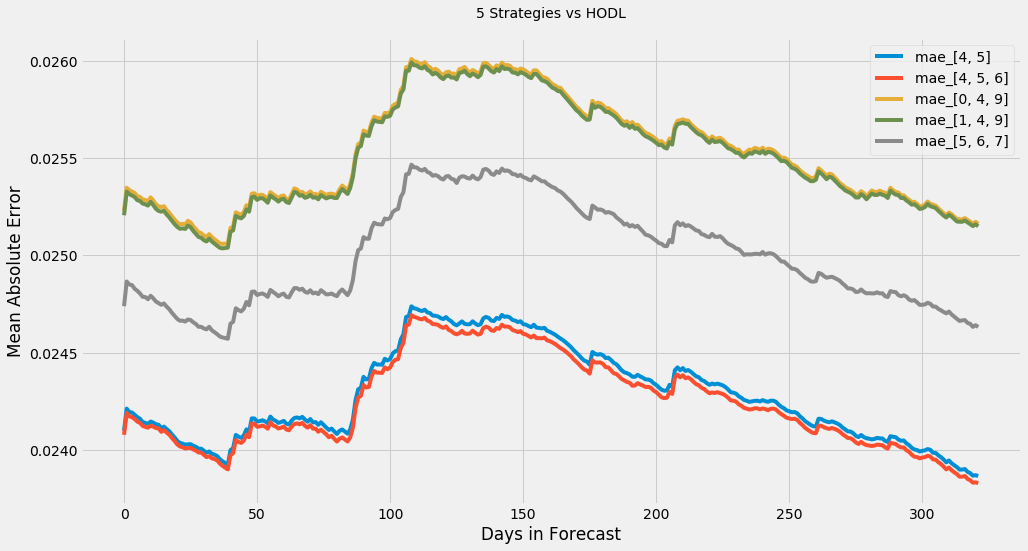

In [125]:
_=plt.figure(figsize=(15,8))
_=plt.title(f'{len(test_voting_mae)} Strategies vs HODL', y=1.03, fontsize=14)
_=plt.ylabel('Mean Absolute Error')
_=plt.xlabel('Days in Forecast', y=1.03)
for i in test_voting_mae:
    _= plt.plot(i[1], label=i[0])
               
_=plt.legend()

In [94]:
test_voting = pd.read_csv('../data/test_voting_step.csv', index_col='date', parse_dates=True)
test_voting.head()

,"[4, 5]","[4, 5, 6]","[0, 4, 9]","[1, 4, 9]","[5, 6, 7]"
date,,,,,
2019-04-02,0.021744,0.018998,0.009606,0.009960,0.027160
2019-04-03,0.020966,0.018492,0.011101,0.011491,0.027911
2019-04-04,0.015494,0.013225,0.009464,0.009989,0.023035
2019-04-05,0.015529,0.013287,0.009365,0.010022,0.022500
2019-04-06,0.015570,0.013360,0.009210,0.009990,0.022464


In [97]:
for col in test_voting.columns:
    test_voting[f'{col}_v'] = test_voting[col].apply(classifier)

In [98]:
test_voting.head()

,"[4, 5]","[4, 5, 6]","[0, 4, 9]","[1, 4, 9]","[5, 6, 7]","[4, 5]_v","[4, 5, 6]_v","[0, 4, 9]_v","[1, 4, 9]_v","[5, 6, 7]_v"
date,,,,,,,,,,
2019-04-02,0.021744,0.018998,0.009606,0.009960,0.027160,1,1,1,1,1
2019-04-03,0.020966,0.018492,0.011101,0.011491,0.027911,1,1,1,1,1
2019-04-04,0.015494,0.013225,0.009464,0.009989,0.023035,1,1,1,1,1
2019-04-05,0.015529,0.013287,0.009365,0.010022,0.022500,1,1,1,1,1
2019-04-06,0.015570,0.013360,0.009210,0.009990,0.022464,1,1,1,1,1


In [99]:
voting_cols = [col for col in test_voting.columns if 'v' in col]
test_votes = test_voting[voting_cols]

In [100]:
test_votes.head()

,"[4, 5]_v","[4, 5, 6]_v","[0, 4, 9]_v","[1, 4, 9]_v","[5, 6, 7]_v"
date,,,,,
2019-04-02,1,1,1,1,1
2019-04-03,1,1,1,1,1
2019-04-04,1,1,1,1,1
2019-04-05,1,1,1,1,1
2019-04-06,1,1,1,1,1


In [101]:
test_votes['sum_votes'] = test_votes.sum(axis=1)

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [103]:
test_votes['prediction'] = test_votes['sum_votes'].apply(decision_rule)

C:\Users\achil\Anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
test_votes.head()

,"[4, 5]_v","[4, 5, 6]_v","[0, 4, 9]_v","[1, 4, 9]_v","[5, 6, 7]_v",sum_votes,prediction
date,,,,,,,
2019-04-02,1,1,1,1,1,5,1
2019-04-03,1,1,1,1,1,5,1
2019-04-04,1,1,1,1,1,5,1
2019-04-05,1,1,1,1,1,5,1
2019-04-06,1,1,1,1,1,5,1


In [105]:
test_votes = test_votes.join(y_test, how='left')

In [106]:
test_votes['btc_classified'] = test_votes.btc_return.apply(classifier)

In [107]:
test_votes.head()

,"[4, 5]_v","[4, 5, 6]_v","[0, 4, 9]_v","[1, 4, 9]_v","[5, 6, 7]_v",sum_votes,prediction,btc_return,btc_classified
date,,,,,,,,,
2019-04-02,1,1,1,1,1,5,1,0.160042,1
2019-04-03,1,1,1,1,1,5,1,0.018907,1
2019-04-04,1,1,1,1,1,5,1,-0.010150,0
2019-04-05,1,1,1,1,1,5,1,0.022870,1
2019-04-06,1,1,1,1,1,5,1,0.004583,1


In [109]:
test_voting_returns = voting_returns(test_votes.prediction, test_votes.btc_classified, test_votes.btc_return)

In [110]:
test_voting_returns

2019-04-02    0.160042
2019-04-03    0.018907
2019-04-04   -0.010150
2019-04-05    0.022870
2019-04-06    0.004583
                ...   
2020-02-13   -0.010874
2020-02-14    0.009523
2020-02-15    0.041854
2020-02-16   -0.004541
2020-02-17    0.031108
Length: 322, dtype: float64

In [204]:
# btc cumulative return over the forecast period
btc_cum = test_votes.btc_return.cumsum()[-1]

In [205]:
# Voting Classifier cumulative return over the forecast period
vc_cum = test_voting_returns.cumsum()[-1]

In [206]:
# net cumulative returns over the forecast period
vc_cum - btc_cum

3.4782581969950366

#### Confusion matrix for voting classifier: Backtest

In [113]:
print(classification_report(test_votes['btc_classified'], test_votes['prediction']))

              precision    recall  f1-score   support

           0       0.62      0.68      0.65       155
           1       0.68      0.61      0.64       167

    accuracy                           0.65       322
   macro avg       0.65      0.65      0.65       322
weighted avg       0.65      0.65      0.65       322



In [114]:
# confusion matrix on test data
test_conf_matrix = pd.DataFrame(confusion_matrix(test_votes['btc_classified'], test_votes['prediction']),
                           index = ['actual negative', 'actual positive'], 
                           columns = ['predicted negative', 'predicted positive'])
test_conf_matrix

,predicted negative,predicted positive
actual negative,106,49
actual positive,65,102


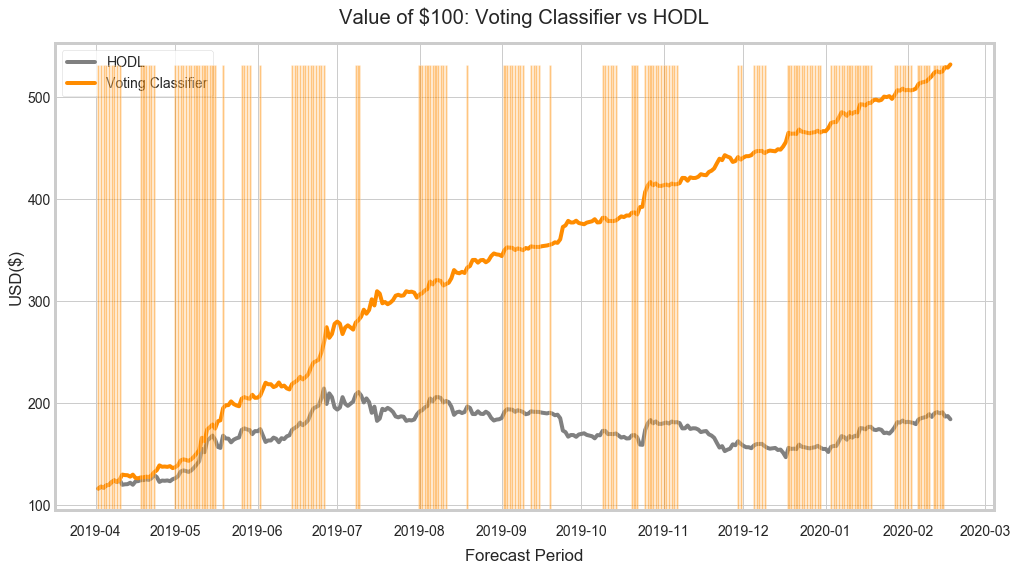

In [197]:
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()
ax1.set_title('Value of $100: Voting Classifier vs HODL', y=1.03)
ax1.set_ylabel('USD($)')
ax1.plot(100 * (1 + test_votes.btc_return.cumsum()), label='HODL', color='gray')
ax1.plot(100 * (1 + test_voting_returns.cumsum()), label='Voting Classifier', color='#FF8C00')
ax2.bar(test_votes.index, test_votes.prediction, label = 'Signal', color='#FF8C00', alpha=0.5)
ax1.set_xlabel('Forecast Period', labelpad=10)
ax1.tick_params(axis='x', pad=15)
ax2.tick_params(axis='y', grid_alpha=0, labelcolor='white')
ax1.legend()

In [10]:
df['pct_close_d'] = df.close.pct_change() #daily percent change
df.pct_close_d.isna().value_counts()

False    1979
True        1
Name: pct_close_d, dtype: int64

(array([  1.,   0.,   1.,   1.,   1.,   2.,   1.,   2.,   2.,   2.,   6.,
         11.,  10.,   7.,  17.,  25.,  36.,  33.,  52.,  84., 125., 185.,
        387., 345., 203., 132.,  86.,  64.,  48.,  29.,  19.,  11.,  10.,
         11.,   8.,   6.,   4.,   2.,   1.,   4.,   0.,   2.,   0.,   0.,
          1.,   0.,   0.,   0.,   1.,   1.]),
 array([-0.21144862, -0.20217021, -0.19289181, -0.1836134 , -0.17433499,
        -0.16505659, -0.15577818, -0.14649978, -0.13722137, -0.12794296,
        -0.11866456, -0.10938615, -0.10010774, -0.09082934, -0.08155093,
        -0.07227253, -0.06299412, -0.05371571, -0.04443731, -0.0351589 ,
        -0.02588049, -0.01660209, -0.00732368,  0.00195472,  0.01123313,
         0.02051154,  0.02978994,  0.03906835,  0.04834676,  0.05762516,
         0.06690357,  0.07618197,  0.08546038,  0.09473879,  0.10401719,
         0.1132956 ,  0.12257401,  0.13185241,  0.14113082,  0.15040923,
         0.15968763,  0.16896604,  0.17824444,  0.18752285,  0.19680126,
 

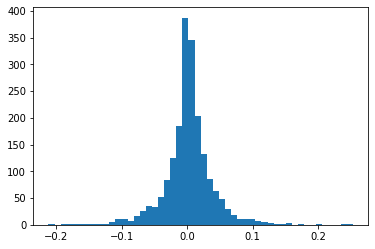

In [79]:
# distribution of daily returns is approximately normal and centered at zero
plt.hist(df['pct_close_d'], bins=50)

#### Results Discussion
- simulate 1000 random guess forecasts and test whether my results are significantly different
- discuss return vs simulation and buy and hold strategy
- correlation of strategy returns with bitcoin returns
- look at best model to see if residuals improve
- I focus on accuracy because of outcomes. For all outcomes where the model is wrong, there is a cost

#### Accuracy of models vs random chance

In [131]:
 def binomial_trials(observed, n_trials):
    '''function to simulate a frequency distribution of accuracy for a series
    fair coin flips at guessing whether tomorrow's return will be positive or negative'''
    accuracy_distribution = []
    for i in range(n_trials):
        trial = np.random.binomial(size=len(observed),n=1,p=0.5)
        accuracy = np.sum(np.abs(observed - trial)) / len(observed)
        accuracy_distribution.append(accuracy)
    return accuracy_distribution

In [132]:
# simulate 10,000 trials of random chance accuracy over forecast period
random_guess = binomial_trials(test_votes.btc_classified, 10000)

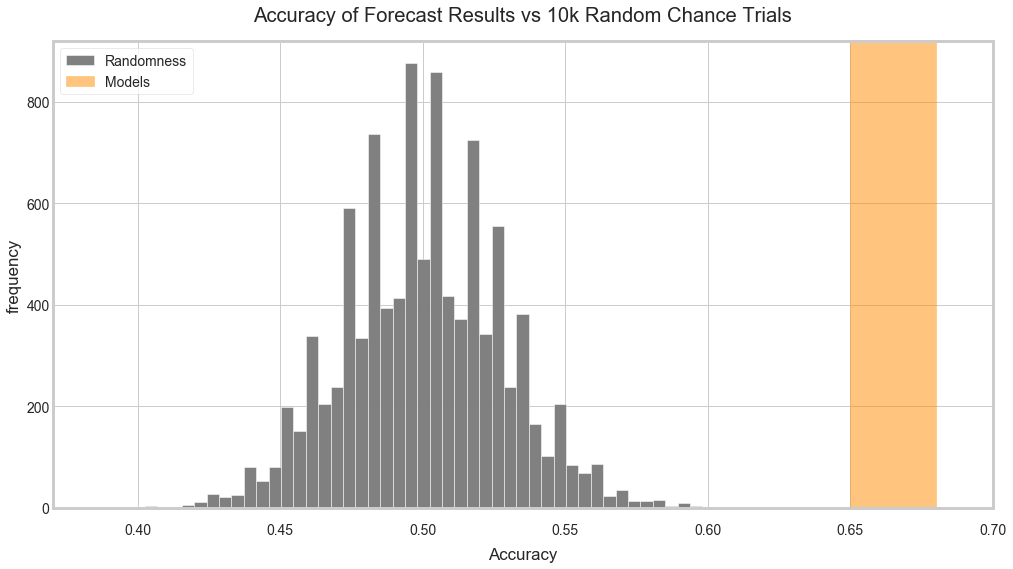

In [220]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Accuracy of Forecast Results vs 10k Random Chance Trials', y=1.03)
ax.set_ylabel('frequency')
ax.set_xlabel('Accuracy', labelpad=10)
ax.hist(random_guess, bins=50, color='gray', label='Randomness')
ax.axvspan(0.65, 0.68, alpha=0.5, color='#FF8C00', label='Models')
ax.tick_params(axis='x', pad=15)
_=plt.legend()
_=plt.xlim(right=0.70)

**Result:** Model accuracy scores are significantly higher than outcomes from random chance. Reject the null hypothesis that that model results are not significantly different from guessing.
#### Rolling returns vs btc

In [216]:
from matplotlib.ticker import FuncFormatter # to format y axis as percent

In [213]:
# rolling 7 day returns for btc and voting classifier
vc_7d = test_voting_returns.rolling(7).sum().dropna()
btc_7d = test_votes.btc_return.rolling(7).sum().dropna()

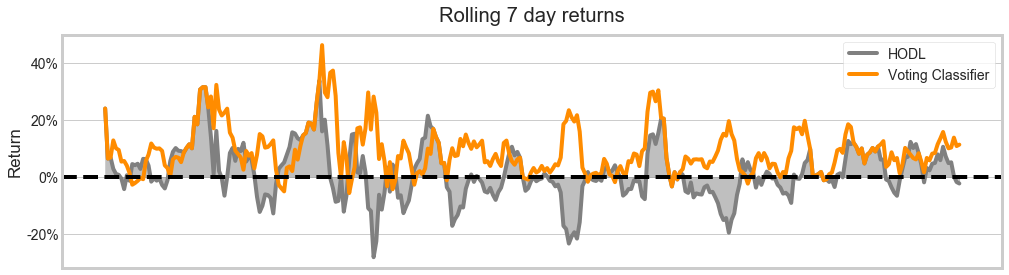

In [233]:
fig, ax = plt.subplots(figsize=(15,4))
ax.set_title('Rolling 7 day returns', y=1.03)
ax.set_ylabel('Return')
# ax.set_xlabel('Forecast Period', labelpad=10)
ax.plot(btc_7d, label='HODL', color='gray')
ax.plot(vc_7d, label='Voting Classifier', color='#FF8C00')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax.tick_params(axis='x', pad=15)
ax.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
ax.fill_between(btc_7d.index, btc_7d, color='gray', alpha='0.5')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False, # labels along the bottom edge are off
    grid_alpha=0) 
ax.legend()

#### Areas for Further Exploration
- Adjust cost function to penalize false positives
- try sliding window versus expanding for training data increment
- look at weekly and monthly returns as autocorrelation is stronger (see below)
- More features: test cointegration between bitcoin price and network value using Metcalfe’s law with a few exponent variants https://arxiv.org/abs/1803.05663
- More combinations: ARIMAX combinations of >3 exogenous variables
- Additional Models: gradient boosting, KNN, LSTM, VAR… stack combinations of these with my current ARMAX and RF models 

In [74]:
# calculate daily autocorrelation
autocorrelation_1d = df.pct_close_d.autocorr()
print(f'autocorrelation of daily returns is {round(autocorrelation_1d*100,2)}%')

autocorrelation of daily returns is 0.39%


In [69]:
# resample and calculate weekly autocorrelation
weekly_df = df.copy()
weekly_df.drop('pct_close_d',1, inplace=True)
weekly_df.index = pd.to_datetime(weekly_df.index)
weekly_df = weekly_df.resample(rule='W').last()
weekly_df['pct_close_w'] = weekly_df.close.pct_change()

In [75]:
autocorrelation_1w = weekly_df.pct_close_w.autocorr()
print(f'autocorrelation of weekly returns is {round(autocorrelation_1w*100,2)}%')

autocorrelation of weekly returns is 2.25%


In [76]:
# resample and calculate monthly autocorrelation
monthly_df = df.copy()
monthly_df.drop('pct_close_d',1, inplace=True)
monthly_df.index = pd.to_datetime(monthly_df.index)
monthly_df = monthly_df.resample(rule='M').last()
monthly_df['pct_close_m'] = monthly_df.close.pct_change()

In [77]:
#Note: volumn column should be dropped for weekly and monthly due to resample rule used
# write a function that calculates autocorrelation over resample periods until it peaks
autocorrelation_1m = monthly_df.pct_close_m.autocorr()
print(f'autocorrelation of monthly returns is {round(autocorrelation_1m*100,2)}%')

autocorrelation of weekly returns is 14.84%


Stocks tend to be negatively autocorrelated over horizons of about a week (i.e. mean reverting). In other words, the market tends to over-react on good news and the stock reverts down or over-react to bad news, and subsequently the stock reverts up. This is a simple strategy that some hedge funds employ. Commodities and currencies on the other hand tend to have positive autocorrelation over a period of several months, so a popular strategy is to buy the instruments that have recently gone up. Bitcoin behaves more like commodities and currencies - it exhibits positive autocorrelation. 